Please note that some sections may be *compressed*. These can be expanded using the *arrows* next to each section title.

This experimentation is split into three main sections:
- Setup
- Experimentation
- Final Analysis

# Setup
This section involves creating necessary **variables, functions** and **architecture classes**.
Within this section data is also loaded in and preprocessed

## Connect Google Drive Folder

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
cwk_dir ="drive/MyDrive/Cognitive Coursework/summative"

results_dir = os.path.join(cwk_dir, "results")
model_dir = os.path.join(cwk_dir, "models")

Mounted at /content/drive/


## Imports

In [2]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [23]:
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, LayerNormalization, Layer, Attention, MultiHeadAttention, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
import keras

import keras_tuner
from sklearn.metrics import confusion_matrix, classification_report


# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import itertools

## Primary Variables

In [4]:
BEST_ACCURACY: float = 0.0
BEST_LOSS: float = 1000.0
BEST_EXPERIMENT: int = -1

In [5]:
BATCH_SIZE = 128
DEFAULT_EPOCHS = 100
N_EPOCH = DEFAULT_EPOCHS
EPOCHS_TRIALS = 20

# N_CLASSES = 10 #CIFAR 10
N_CLASSES = 100 #CIFAR 100
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
OPTIM = RMSprop(learning_rate=LEARNING_RATE)

#CIFAR100 class names used for the confusion matrix
CIFAR_CLASSES = ["beaver", "dolphin", "otter", "seal", "whale", "aquarium" ,"fish", "ray", "shark", "trout",  "orchids", "poppies", "roses", "sunflowers", "tulips",  "bottles", "bowls", "cans", "cups", "plates",  "apples", "mushrooms", "oranges", "pears", "sweet peppers",  "clock", "computer keyboard", "lamp", "telephone", "television", "bed", "chair", "couch", "table", "wardrobe",  "bee", "beetle", "butterfly", "caterpillar", "cockroach",  "bear", "leopard", "lion", "tiger", "wolf",  "bridge", "castle", "house", "road", "skyscraper",  "cloud", "forest", "mountain", "plain", "sea",  "camel", "cattle", "chimpanzee", "elephant", "kangaroo",  "fox", "porcupine", "possum", "raccoon", "skunk",  "crab", "lobster", "snail", "spider", "worm",  "baby", "boy", "girl", "man", "woman",  "crocodile", "dinosaur", "lizard", "snake", "turtle",  "hamster", "mouse", "rabbit", "shrew", "squirrel",  "maple", "oak", "palm", "pine", "willow",  "bicycle", "bus", "motorcycle", "pickup truck", "train",  "lawn-mower", "rocket", "streetcar", "tank", "tractor"]

In [6]:
HISTORIES = []

In [7]:
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

## Functions

In [8]:
def save_keras_model(model, experiment):
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(model_dir, f"model_{experiment}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(model_dir, f"model_{experiment}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [9]:
def plot_multiple_histories(histories, export_path, legend = ['train', 'test'], include_train: bool = True):
  """
  Will plot multiple histories together, on the same figure
  """
  plt.figure(figsize=(20, 10))
  for history in histories:
    plt.subplot(1, 2, 1)

    if(include_train):
      plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')

    plt.subplot(1, 2, 2)
    if(include_train):
      plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


In [10]:
def update_best_metrics(new_accuracy, new_loss, experiment):
  """
  Maintains a best accuracy & loss for the best experiment. Will output information with this
  """
  global BEST_ACCURACY
  global BEST_LOSS
  global BEST_EXPERIMENT
  if(new_accuracy > BEST_ACCURACY and new_loss < BEST_LOSS):
      print(f"NEW ACCURACY > BEST ACCURACY    {new_accuracy} > {BEST_ACCURACY}    UPDATING BEST ACCURACY TO {new_accuracy}")
      print(f"NEW LOSS > BEST LOSS    {new_loss} < {BEST_LOSS}    UPDATING BEST LOSS TO {new_accuracy}")
      BEST_EXPERIMENT = experiment
      BEST_ACCURACY = new_accuracy
      BEST_LOSS = new_loss
  else:
    print(f"NEW ACCURACY <= BEST ACCURACY    {new_accuracy} <= {BEST_ACCURACY}")
    print(f"NEW LOSS <= BEST LOSS    {new_loss} >= {BEST_LOSS}")
  print(f"BEST EXPERIMENT: {BEST_EXPERIMENT}")

In [11]:
def evaluate_model(model, experiment):
  """
  Evaluates the input model against the test datasets & outputs their accuracy & loss
  """
  score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

  accuracy = score[1]
  loss = score[0]

  print("\nTest score/loss:", loss)
  print('Test accuracy:', accuracy)
  update_best_metrics(new_accuracy=accuracy, new_loss=loss, experiment=experiment)

In [12]:
def plot_save_model(model, filename):
  """
  Plots the model, saves this to a file and loads it back in to display
  """
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [13]:
def analyse_model(model, history, experiment, add_to_history: bool = True):
  """
  Plots the history of a model and evaluates it. Saves the history
  """
  plot_multiple_histories(histories=[history], export_path=f"experiment_{experiment}_metrics.pdf")
  evaluate_model(model=model, experiment=experiment)
  save_keras_model(model=model, experiment=experiment)
  if(add_to_history):
    HISTORIES.append(history)

In [14]:
def make_confusion_matrix(model, filename, experiment):
  """
  Function will get the predicted & true classes and creates a confusion matrix with them. Displays this and saves a version
  """
  #Change to indices of the predictions & true
  preds = [np.argmax(pred) for pred in model.predict(input_X_test)]
  true = [np.argmax(y) for y in output_Y_test]

  #confusion matrix
  conf_mat = confusion_matrix(preds, true)

  #Plot & save
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(211)
  cax = ax.matshow(conf_mat)
  plt.title(f"Confusion Matrix: Experiment {experiment}")
  fig.colorbar(cax)
  ax.set_xticklabels(CIFAR_CLASSES)
  ax.set_yticklabels(CIFAR_CLASSES)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.savefig(os.path.join(results_dir, filename)) #Save to the filepath specified
  plt.show()

  #Show the classification report
  cls_report = classification_report(true, preds, target_names=CIFAR_CLASSES, digits=3)
  print(cls_report)

## Architecture Functions
These functions create more complex and commonly used groups of layers

In [15]:
def Res_Connection(x, layer_size=32, kernel_size=3, pool_size=2, activation="relu"):
  """
  Residual connection for CNN block. Made up for convolutional layers, normalisation and add layers for the skip connection
  """
  inputs = x

  x = Conv2D(layer_size, kernel_size=kernel_size, padding='same')(x)
  x = Activation(activation)(x)
  x = BatchNormalization()(x)

  x = Conv2D(layer_size, kernel_size=kernel_size, padding='same')(x)
  x = Add()([x,inputs]) #Skip connection here, prior to activation
  x = Activation(activation)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
  return x

In [16]:
def Self_Multi_Attention(x, key_dims, num_heads=3, epsilon=1e-6):
  """
  Multi-head self-attention block. Made up for multi-head attention, an add layer and then normalisation layer
  """
  inputs = x

  x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims)(x,x)
  x = Add()([x, inputs])
  x = LayerNormalization(epsilon=epsilon)(x)
  return x

## Dataset(s)

In [17]:
#load dataset
(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data()
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')

# convert to categorical
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)

# float and normalization
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 [==============================] - 7s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#Experimentation

Overall 5 primary experiments were conducted, the 5th being the largest:
1. A **plain CNN**
2. A CNN with **residual** (or skip) connections
3. A CNN with **multi-head attention** blocks
4. A CNN with **both** residual connections & multi-head attention blocks
5. Experimentation with the **size of the network**. Involved varying:
  - **Width** of convolutional layers: [32, 64, 128]
  - Number of **network blocks**: [1,2,3]

Once the optimal network and hyperparameters were discovered, a final model was trained. This model utilised **early stopping, data augmentation and learning rate scheduling** to improve results further.


### Experiment 1: Plain CNN
Here we trial a very basic CNN architecture, the one presented in the labs, to get a baseline for performance. This will be the baseline for comparison of the later models created

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 5, 5, 64)          36928     
                                                      

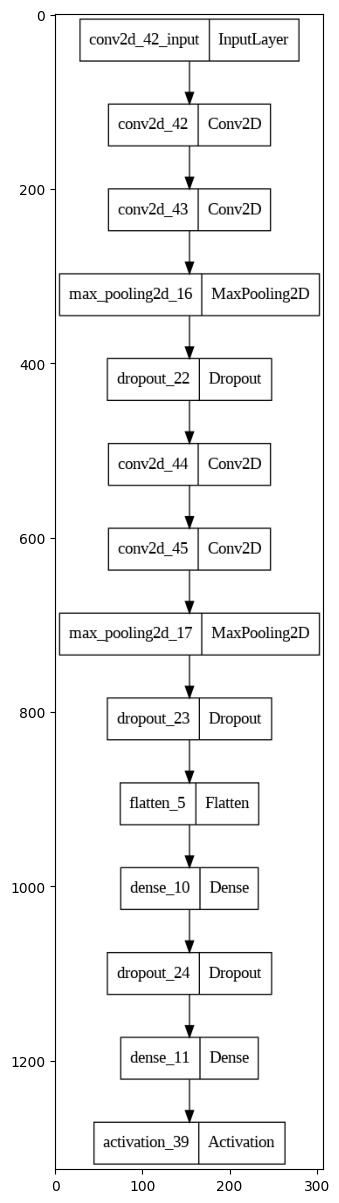

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size=3, padding='same',activation='relu', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model_1.add(Conv2D(32, kernel_size=3, padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, kernel_size=3, padding='same',activation='relu'))
model_1.add(Conv2D(64, 3, 3,activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(N_CLASSES))
model_1.add(Activation('softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

model_1.summary()
#Shows a more readable form of the DNN
plot_save_model(model_1, filename="experiment_1_arch.png")

In [ ]:
#Train first model
history_1 = model_1.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Epoch 1/100
313/313 [==============================] - 5s 11ms/step - loss: 4.5866 - accuracy: 0.0154 - val_loss: 4.4758 - val_accuracy: 0.0277
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 4.4167 - accuracy: 0.0269 - val_loss: 4.3045 - val_accuracy: 0.0404
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 4.3148 - accuracy: 0.0360 - val_loss: 4.2100 - val_accuracy: 0.0637
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 4.2360 - accuracy: 0.0467 - val_loss: 4.1199 - val_accuracy: 0.0816
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 4.1562 - accuracy: 0.0580 - val_loss: 4.0273 - val_accuracy: 0.1022
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 4.0701 - accuracy: 0.0722 - val_loss: 3.9303 - val_accuracy: 0.1092
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 3.9909 - accuracy: 0.0854 - val_loss: 3.8479 - val_accuracy: 0.

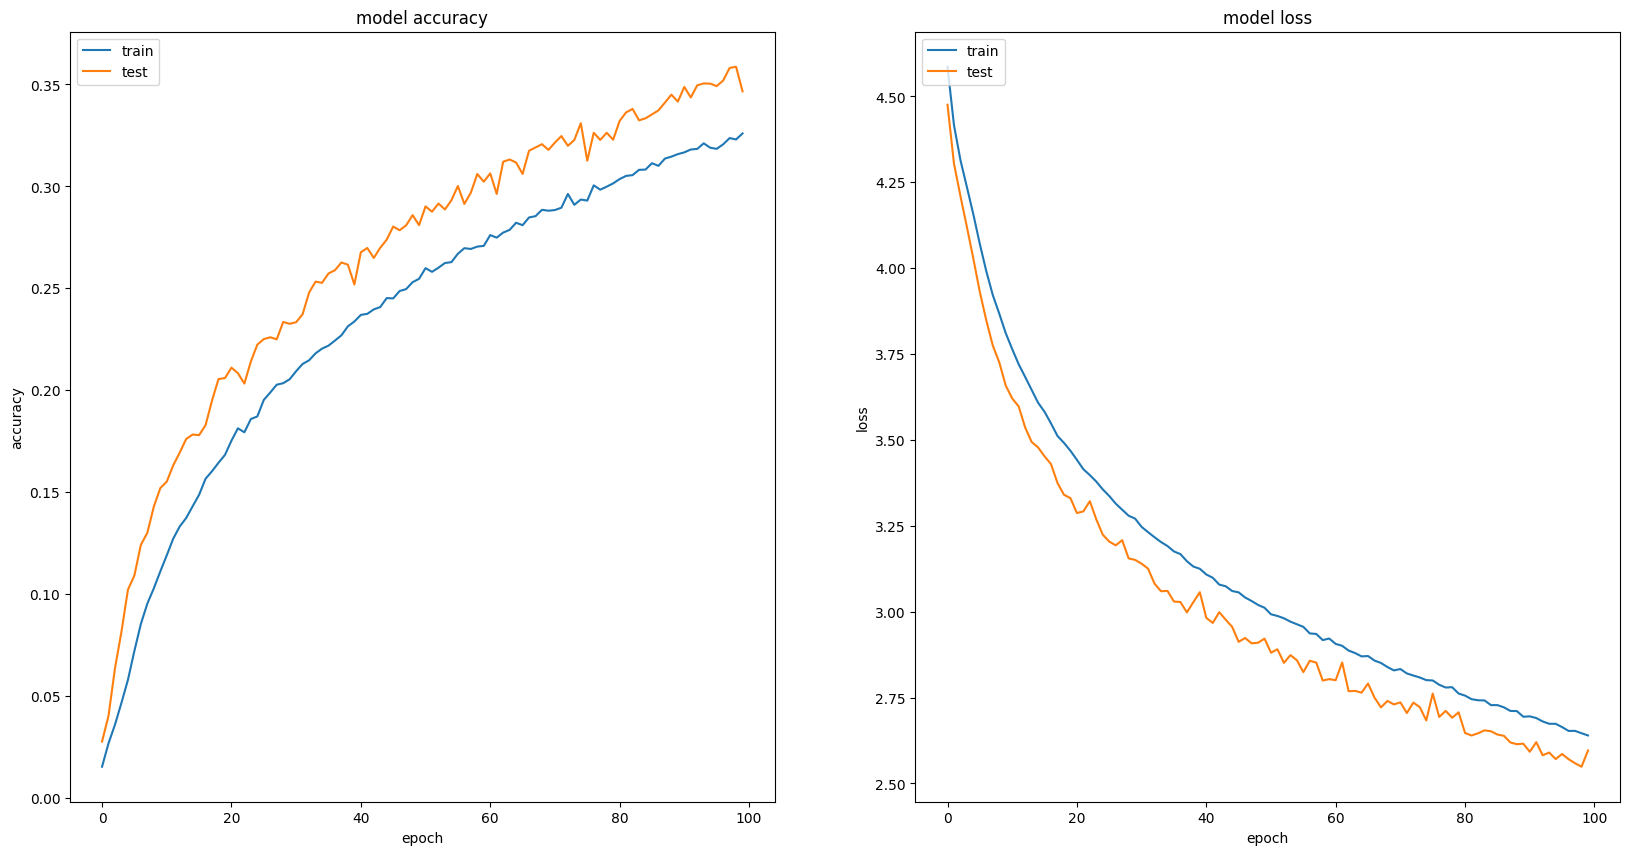

79/79 [==============================] - 0s 4ms/step - loss: 2.5597 - accuracy: 0.3496

Test score/loss: 2.559680700302124
Test accuracy: 0.3495999872684479
NEW ACCURACY > BEST ACCURACY    0.3495999872684479 > 0.0    UPDATING BEST ACCURACY TO 0.3495999872684479
NEW LOSS > BEST LOSS    2.559680700302124 < 1000.0    UPDATING BEST LOSS TO 0.3495999872684479
BEST EXPERIMENT: 1


In [ ]:
analyse_model(model=model_1, history=history_1, experiment=1)

### Experiment 2: CNN with Residual Connections
This experiment will take the previous CNN architecture and add in **residual connections**. This will change the output of certain convolutionals layers to be the addition of the input to the previous layer & the input to the current layer

*Related Papers:*
*   https://ieeexplore.ieee.org/abstract/document/7777858

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_56 (Conv2D)          (None, 32, 32, 32)           896       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_54 (Ba  (None, 32, 32, 32)           128       ['conv2d_56[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 16, 16, 32)           0         ['batch_normalization_54

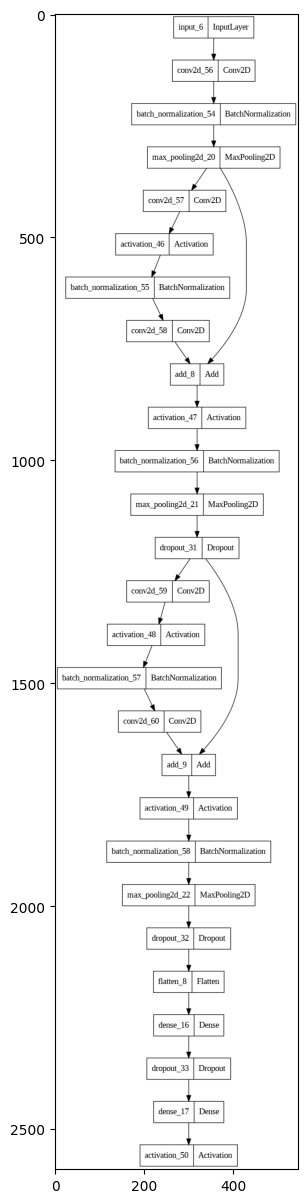

In [ ]:
inputs = Input(shape=INPUT_SHAPE)

x = Conv2D(32, kernel_size=3, padding='same',activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Res_Connection(x=x, layer_size=32, kernel_size=3, pool_size=2)
x = Dropout(0.25)(x)

x = Res_Connection(x=x, layer_size=32, kernel_size=3, pool_size=2)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(N_CLASSES)(x)
outputs = Activation('softmax')(x)

model_2 = Model(
  inputs=[inputs],
  outputs=[outputs],
)

model_2.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
plot_save_model(model_2, filename="experiment_2_arch.png")

model_2.summary()

In [ ]:
history_2 = model_2.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Epoch 1/100
313/313 [==============================] - 6s 12ms/step - loss: 4.6698 - accuracy: 0.0384 - val_loss: 4.7675 - val_accuracy: 0.0176
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 4.0998 - accuracy: 0.0808 - val_loss: 3.8329 - val_accuracy: 0.1401
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 3.8600 - accuracy: 0.1134 - val_loss: 3.5893 - val_accuracy: 0.1752
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 3.6883 - accuracy: 0.1414 - val_loss: 3.4390 - val_accuracy: 0.2019
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 3.5455 - accuracy: 0.1640 - val_loss: 3.3225 - val_accuracy: 0.2215
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 3.4228 - accuracy: 0.1843 - val_loss: 3.2130 - val_accuracy: 0.2426
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 3.3283 - accuracy: 0.2008 - val_loss: 3.1209 - val_accuracy: 0.25

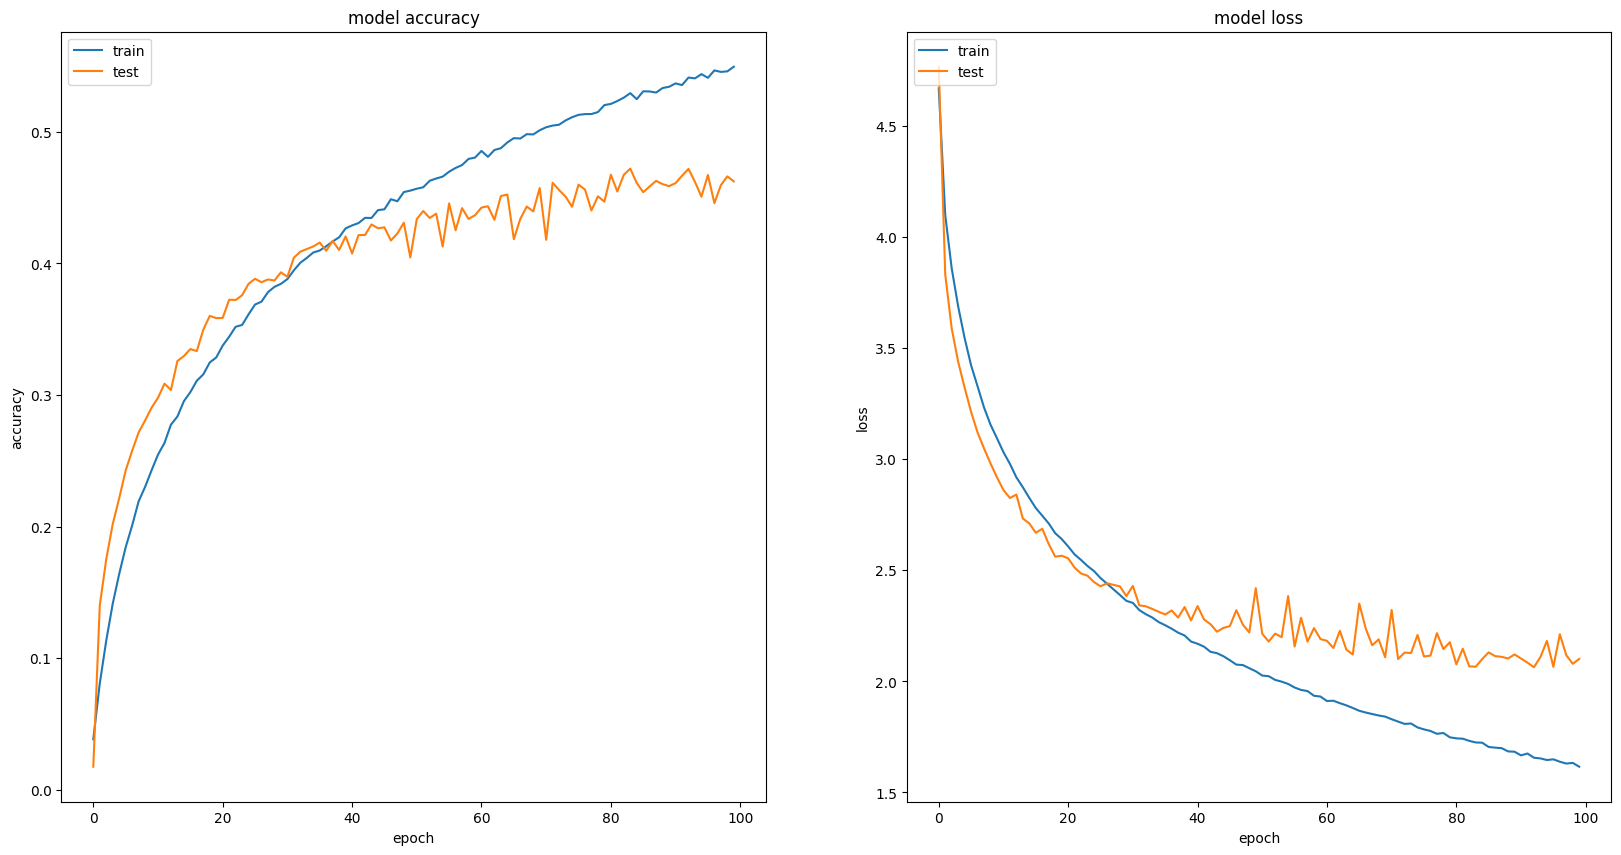

79/79 [==============================] - 0s 4ms/step - loss: 2.0559 - accuracy: 0.4748

Test score/loss: 2.055887222290039
Test accuracy: 0.4747999906539917
NEW ACCURACY > BEST ACCURACY    0.4747999906539917 > 0.3495999872684479    UPDATING BEST ACCURACY TO 0.4747999906539917
NEW LOSS > BEST LOSS    2.055887222290039 < 2.559680700302124    UPDATING BEST LOSS TO 0.4747999906539917
BEST EXPERIMENT: 2


In [ ]:
analyse_model(model=model_2, history=history_2, experiment=2)

### Experiment 3: CNN with Attention
This experiment will take the first CNN architecture and add in **attention**.

*Related Papers:*
*   https://ieeexplore.ieee.org/abstract/document/9561397


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_83 (Conv2D)          (None, 32, 32, 32)           896       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_78 (Ba  (None, 32, 32, 32)           128       ['conv2d_83[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_42 (MaxPooli  (None, 16, 16, 32)           0         ['batch_normalization_78

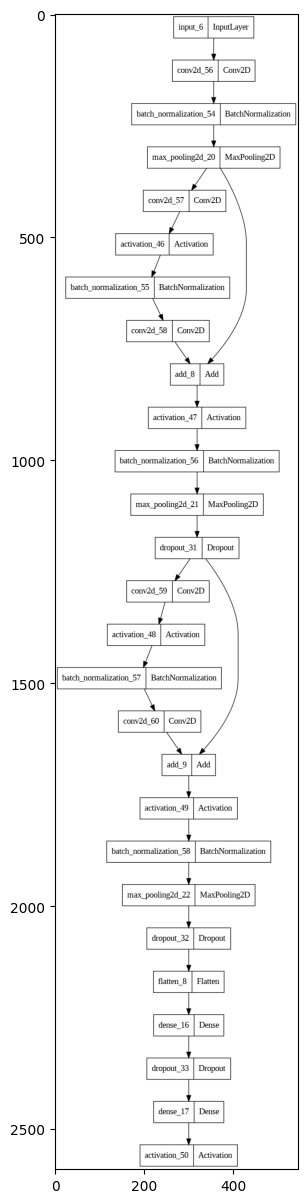

In [ ]:
inputs = Input(shape=INPUT_SHAPE)

x = Conv2D(32, kernel_size=3, padding='same',activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Self_Multi_Attention(x=x, num_heads=3, key_dims=np.shape(x)[-1])
x = Dropout(0.25)(x)

x = Conv2D(32, kernel_size=3, padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Self_Multi_Attention(x=x, num_heads=3, key_dims=np.shape(x)[-1])
x = Dropout(0.25)(x)

x = Conv2D(32, kernel_size=3, padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Self_Multi_Attention(x=x, num_heads=3, key_dims=np.shape(x)[-1])
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(N_CLASSES)(x)
outputs = Activation('softmax')(x)

model_3 = Model(
  inputs=[inputs],
  outputs=[outputs],
)

model_3.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
plot_save_model(model_2, filename="experiment_3_arch.png")

model_3.summary()

In [ ]:
history_3 = model_3.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Epoch 1/100
313/313 [==============================] - 12s 23ms/step - loss: 4.6352 - accuracy: 0.0362 - val_loss: 4.0807 - val_accuracy: 0.0844
Epoch 2/100
313/313 [==============================] - 7s 23ms/step - loss: 4.0863 - accuracy: 0.0836 - val_loss: 3.7266 - val_accuracy: 0.1379
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 3.8492 - accuracy: 0.1133 - val_loss: 3.5382 - val_accuracy: 0.1727
Epoch 4/100
313/313 [==============================] - 13s 40ms/step - loss: 3.6866 - accuracy: 0.1369 - val_loss: 3.3839 - val_accuracy: 0.1972
Epoch 5/100
313/313 [==============================] - 14s 43ms/step - loss: 3.5391 - accuracy: 0.1604 - val_loss: 3.4015 - val_accuracy: 0.1951
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 3.4212 - accuracy: 0.1812 - val_loss: 3.2075 - val_accuracy: 0.2302
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 3.3202 - accuracy: 0.1978 - val_loss: 3.1658 - val_accur

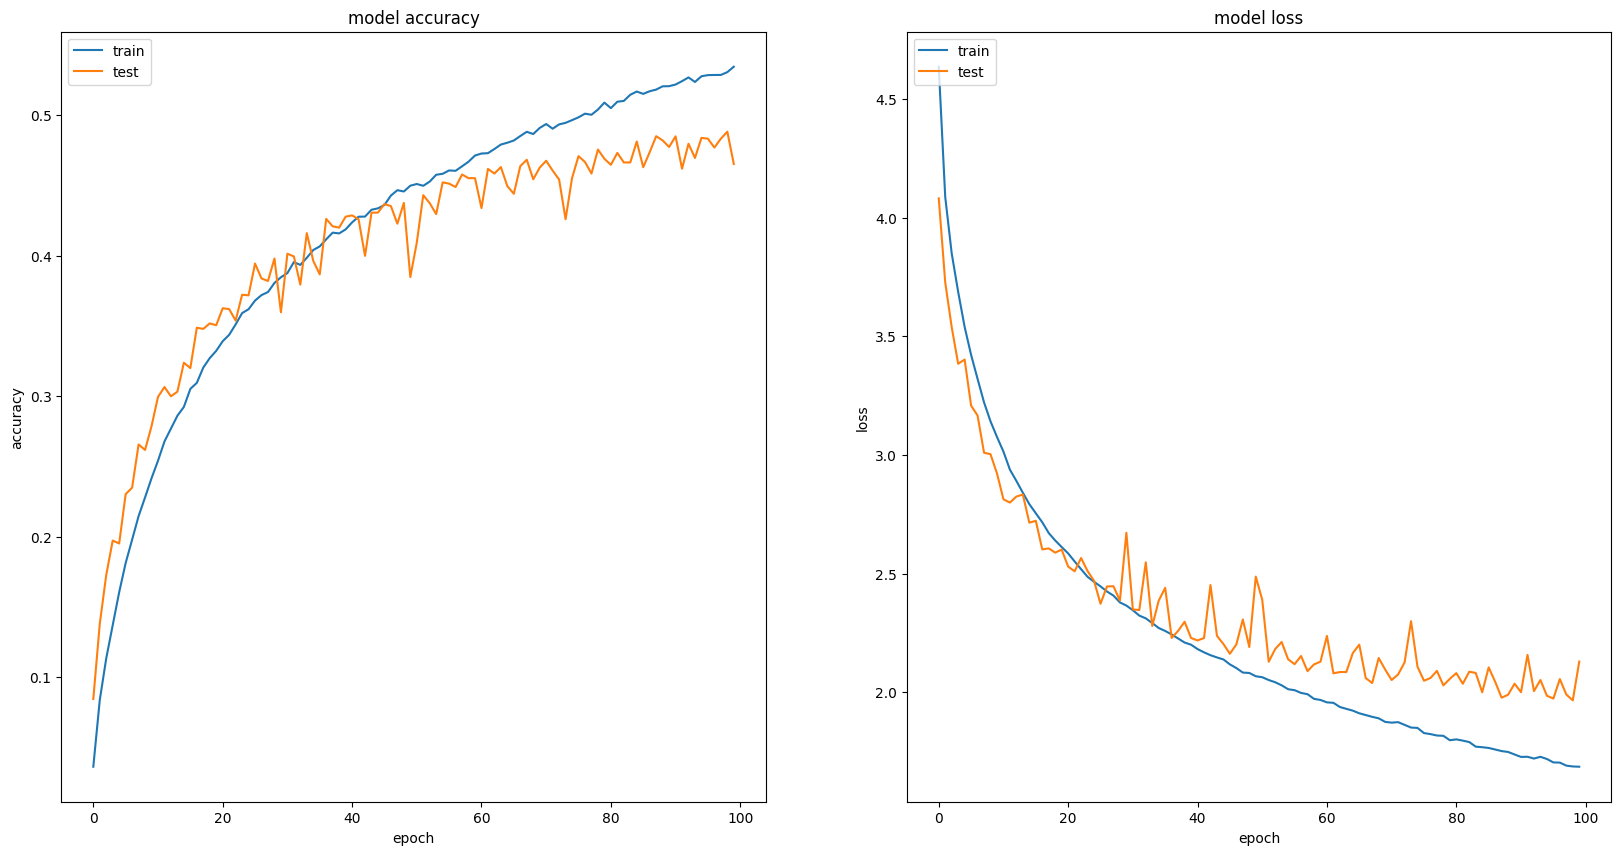

79/79 [==============================] - 1s 8ms/step - loss: 2.1230 - accuracy: 0.4690

Test score/loss: 2.1230366230010986
Test accuracy: 0.4690000116825104
NEW ACCURACY <= BEST ACCURACY    0.4690000116825104 <= 0.4747999906539917
NEW LOSS <= BEST LOSS    2.1230366230010986 >= 2.055887222290039
BEST EXPERIMENT: 2


In [ ]:
analyse_model(model=model_3, history=history_3, experiment=3)

### Experiment 4: CNN with Attention & Residual Connections
Here we combine both experiment 2 & 3. Both these architectures work better than the plain CNN. This experiment evaluates the combination of these together

In [ ]:
def create_experiment4_arch():
  """
  Creates the combination of CNN with attention & residual connections
  """
  inputs = Input(shape=INPUT_SHAPE)

  x = Conv2D(32, kernel_size=3, padding='same',activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Res_Connection(x=x, layer_size=32, kernel_size=3, pool_size=2)
  x = Dropout(0.25)(x)

  x = Res_Connection(x=x, layer_size=32, kernel_size=3, pool_size=2)
  x = Self_Multi_Attention(x=x, num_heads=3, key_dims=np.shape(x)[-1])
  x = Dropout(0.25)(x)

  x = Flatten()(x)
  x = Dense(1024,activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(N_CLASSES)(x)
  outputs = Activation('softmax')(x)

  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
  return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 32)           896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 32, 32, 32)           128       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)           0         ['batch_normalization_10

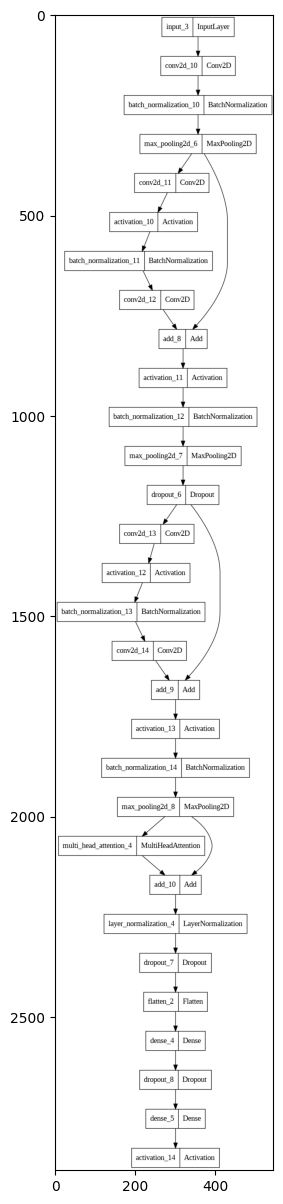

In [ ]:
model_4 = create_experiment4_arch()

model_4.summary()
plot_save_model(model_4, filename="experiment_4_arch.png")

In [ ]:
history_4 = model_4.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Epoch 1/100
313/313 [==============================] - 8s 16ms/step - loss: 4.5405 - accuracy: 0.0431 - val_loss: 4.8640 - val_accuracy: 0.0260
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 3.9986 - accuracy: 0.0934 - val_loss: 3.7091 - val_accuracy: 0.1468
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 3.7539 - accuracy: 0.1294 - val_loss: 3.4449 - val_accuracy: 0.1934
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 3.5747 - accuracy: 0.1597 - val_loss: 3.3183 - val_accuracy: 0.2132
Epoch 5/100
313/313 [==============================] - 4s 11ms/step - loss: 3.4320 - accuracy: 0.1837 - val_loss: 3.1516 - val_accuracy: 0.2478
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 3.3102 - accuracy: 0.2040 - val_loss: 3.0551 - val_accuracy: 0.2617
Epoch 7/100
313/313 [==============================] - 5s 15ms/step - loss: 3.2063 - accuracy: 0.2215 - val_loss: 2.9796 - val_accuracy:

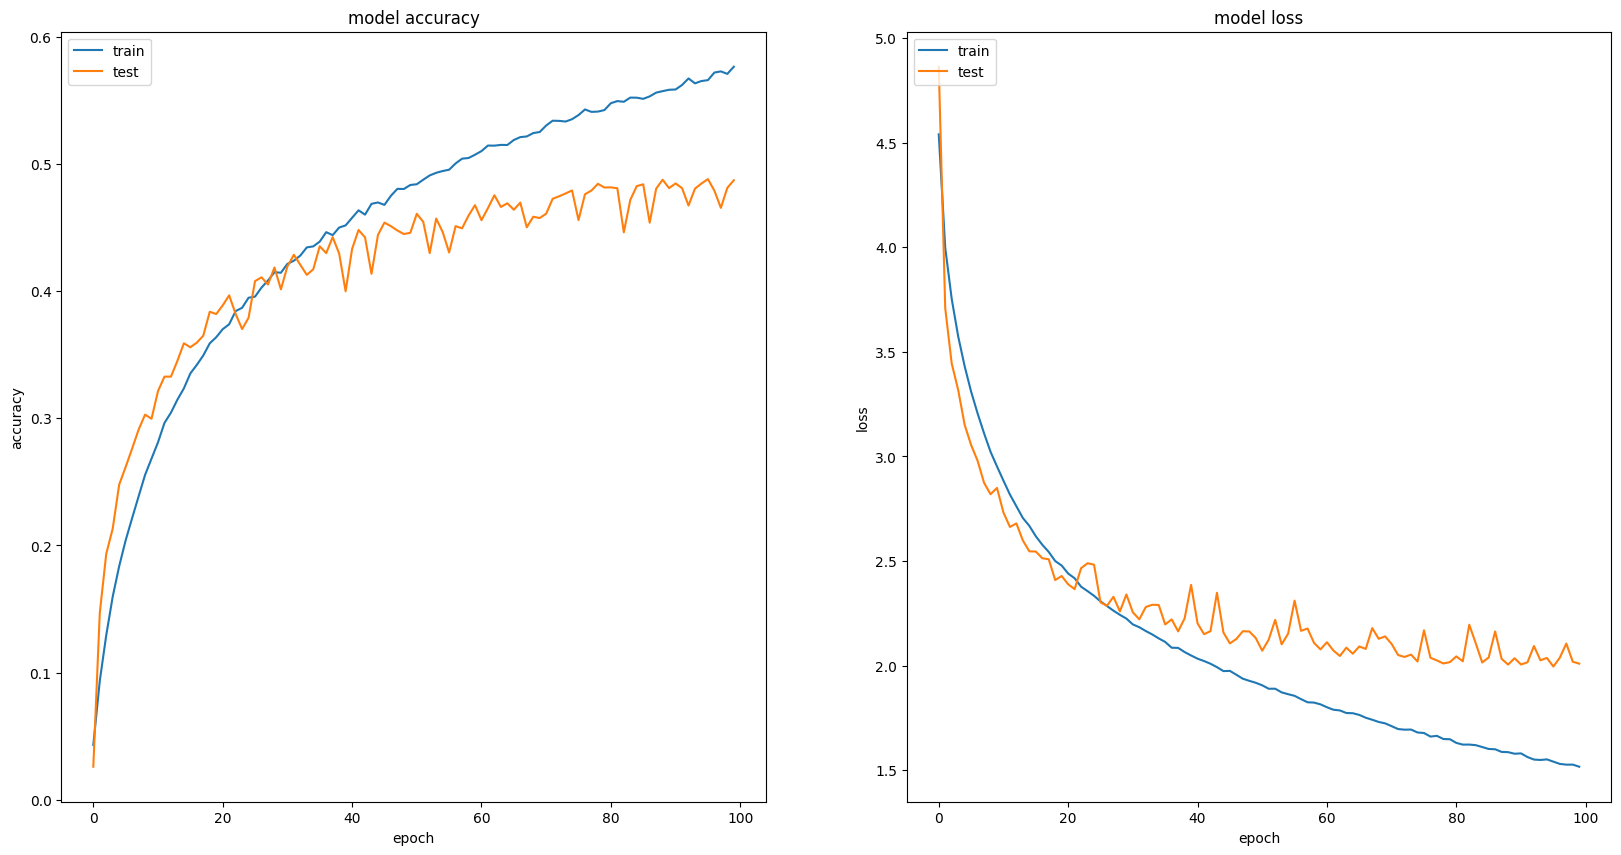

79/79 [==============================] - 1s 10ms/step - loss: 1.9688 - accuracy: 0.4903

Test score/loss: 1.9687711000442505
Test accuracy: 0.4902999997138977
NEW ACCURACY > BEST ACCURACY    0.4902999997138977 > 0.4747999906539917    UPDATING BEST ACCURACY TO 0.4902999997138977
NEW LOSS > BEST LOSS    1.9687711000442505 < 2.055887222290039    UPDATING BEST LOSS TO 0.4902999997138977
BEST EXPERIMENT: 4


In [ ]:
analyse_model(model=model_4, history=history_4, experiment=4)

## Experiment 5: Experiment with Hyperparameters
Uses **Keras Hypertuner** (https://keras.io/guides/keras_tuner/getting_started/), specifically the GridSearch (https://keras.io/api/keras_tuner/tuners/grid/#gridsearch-class) for exhaustive testing, to find the best values of certain hyperparameters for the best model found so far: **experiment 4's model**.

These hyperparameters are:


* Number of **residual** CNN blocks
* **Size of Convolutional layers**


### Experimentation

In [ ]:
CNN_UNITS_KEY: str = 'cnn_units'
RES_BLOCKS_KEY: str = 'res_blocks'

In [ ]:
histories = []
class RecordHistoryCallback(Callback):
  """
  Callback to record the history of each model made in the trials
  """
  def __init__(self):
    super().__init__()
    self.histories = []

  def on_train_end(self, logs=None):
    """
    Adds the history of each completed model to the list
    """
    global histories
    histories.append(self.model.history)

In [ ]:
CNN_UNITS_OPTIONS = [32, 64, 128, 256]
RES_BLOCKS_OPTIONS = [1,2,3]

combinations = [f"CNN: {cnn}, RES: {res}" for cnn in CNN_UNITS_OPTIONS for res in RES_BLOCKS_OPTIONS]

def experiment5_tuner(hp):
  """
  Takes the hypertuner and extracts the parameters from it
  """
  cnn_units = hp.Choice(CNN_UNITS_KEY, CNN_UNITS_OPTIONS)
  res_blocks = hp.Choice(RES_BLOCKS_KEY, RES_BLOCKS_OPTIONS)
  return create_experiment5_arch(cnn_units=cnn_units, res_blocks=res_blocks, mha_heads=3)

def create_experiment5_arch(cnn_units: int = 32, mha_heads: int = 3, res_blocks: int = 2):
  """
  Creates the combination of CNN with attention & residual connections. Changes the model based on the input hyperparameters
  """
  inputs = Input(shape=INPUT_SHAPE)

  x = Conv2D(cnn_units, kernel_size=3, padding='same',activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  for _ in range(res_blocks):
    x = Res_Connection(x=x, layer_size=cnn_units, kernel_size=3, pool_size=2)
    x = Dropout(0.25)(x)

  x = Self_Multi_Attention(x=x, num_heads=mha_heads, key_dims=np.shape(x)[-1])
  x = Flatten()(x)
  x = Dense(1024,activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(N_CLASSES)(x)
  outputs = Activation('softmax')(x)

  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
  return model

In [ ]:
tuner = keras_tuner.GridSearch(
    experiment5_tuner,
    objective='val_loss')

In [ ]:
#Note reduced epochs (20) to save some time whilst still getting good feedback
tuner.search(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS_TRIALS, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE, callbacks=[RecordHistoryCallback()])
model_5 = tuner.get_best_models()[0]

Trial 12 Complete [00h 03m 42s]
val_loss: 1.9521642923355103

Best val_loss So Far: 1.9521642923355103
Total elapsed time: 00h 31m 18s


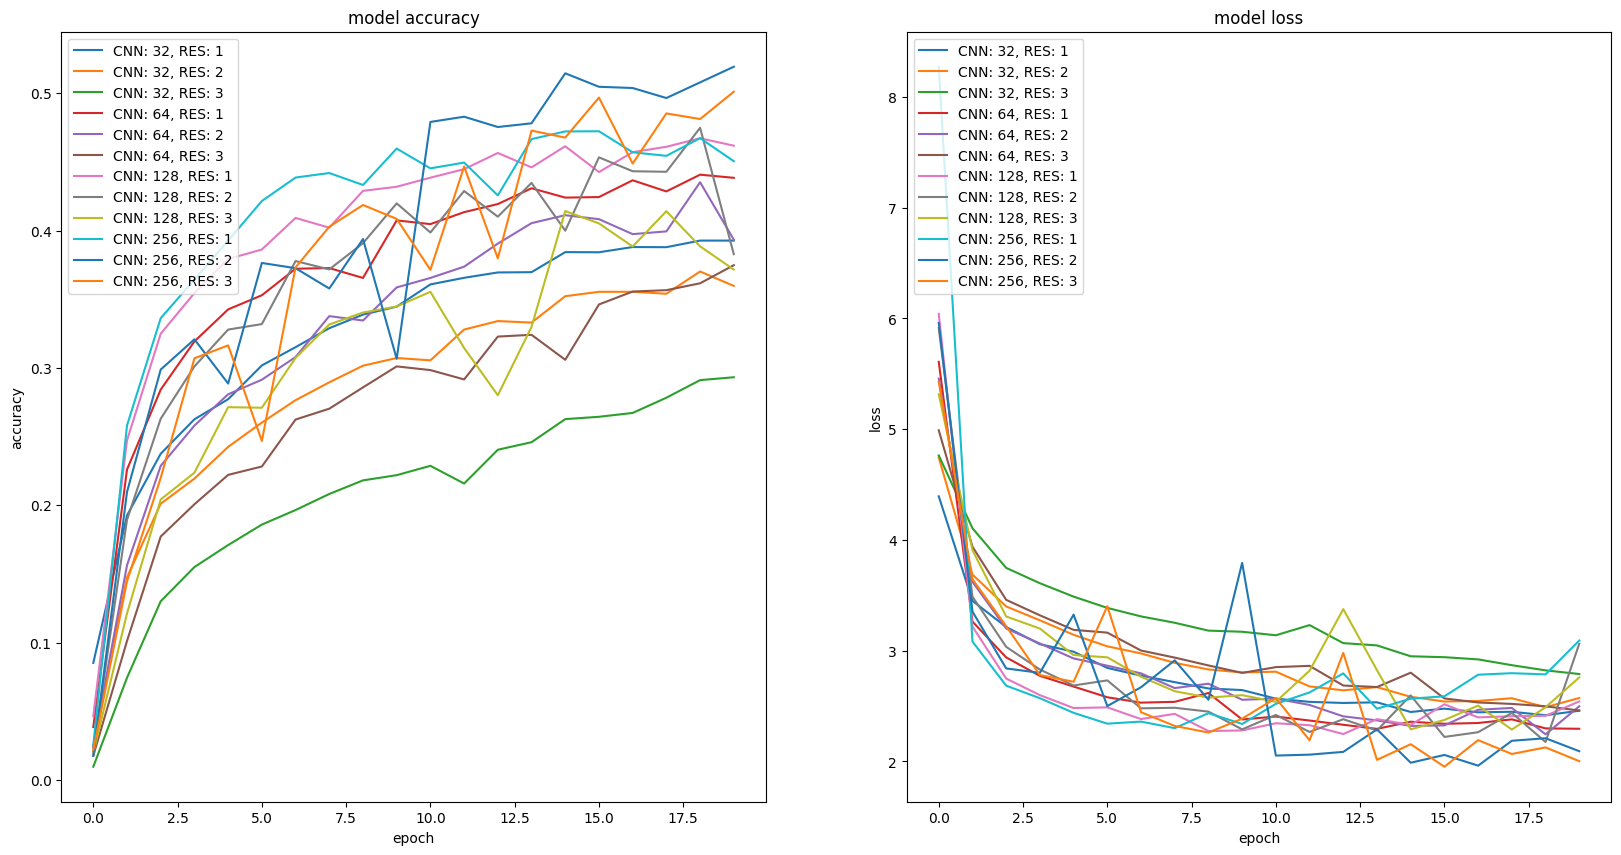

In [ ]:
plot_multiple_histories(histories=histories, export_path=f"experiment_5_trials.pdf", legend=combinations, include_train=False)

In [ ]:
cnn_units = tuner.get_best_hyperparameters()[0][CNN_UNITS_KEY]
res_blocks = tuner.get_best_hyperparameters()[0][RES_BLOCKS_KEY]

print(f"{CNN_UNITS_KEY}: {cnn_units}")
print(f"{RES_BLOCKS_KEY}: {res_blocks}")

cnn_units: 256
res_blocks: 3


### Train Using Best Hyperparameters
Train the rest of the way using these hyperparameters

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 32, 32, 256)          7168      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 32, 32, 256)          1024      ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 256)          0         ['batch_normalization_14

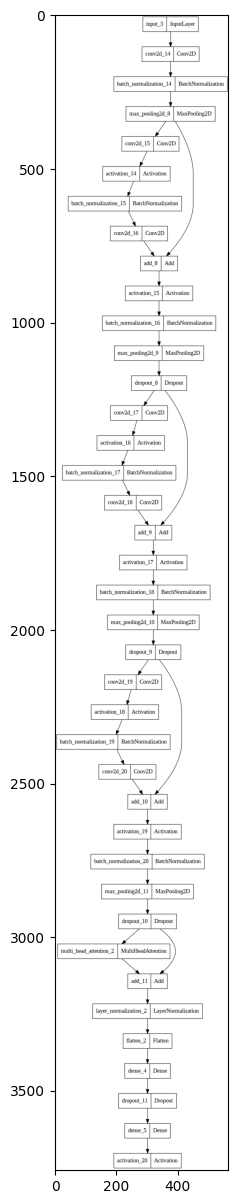

In [ ]:
model_5 = create_experiment5_arch(cnn_units=cnn_units, res_blocks=res_blocks)
model_5.summary()
plot_save_model(model_5, filename="experiment_5_arch.png")

Epoch 1/100
313/313 [==============================] - 14s 35ms/step - loss: 4.2699 - accuracy: 0.0705 - val_loss: 5.4435 - val_accuracy: 0.0216
Epoch 2/100
313/313 [==============================] - 10s 32ms/step - loss: 3.6783 - accuracy: 0.1403 - val_loss: 3.7783 - val_accuracy: 0.1360
Epoch 3/100
313/313 [==============================] - 10s 31ms/step - loss: 3.3505 - accuracy: 0.1941 - val_loss: 3.0534 - val_accuracy: 0.2511
Epoch 4/100
313/313 [==============================] - 10s 32ms/step - loss: 3.0803 - accuracy: 0.2394 - val_loss: 3.0919 - val_accuracy: 0.2676
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 2.8558 - accuracy: 0.2801 - val_loss: 2.7040 - val_accuracy: 0.3210
Epoch 6/100
313/313 [==============================] - 10s 32ms/step - loss: 2.6828 - accuracy: 0.3111 - val_loss: 2.6943 - val_accuracy: 0.3261
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 2.5173 - accuracy: 0.3454 - val_loss: 3.1354 - val_ac

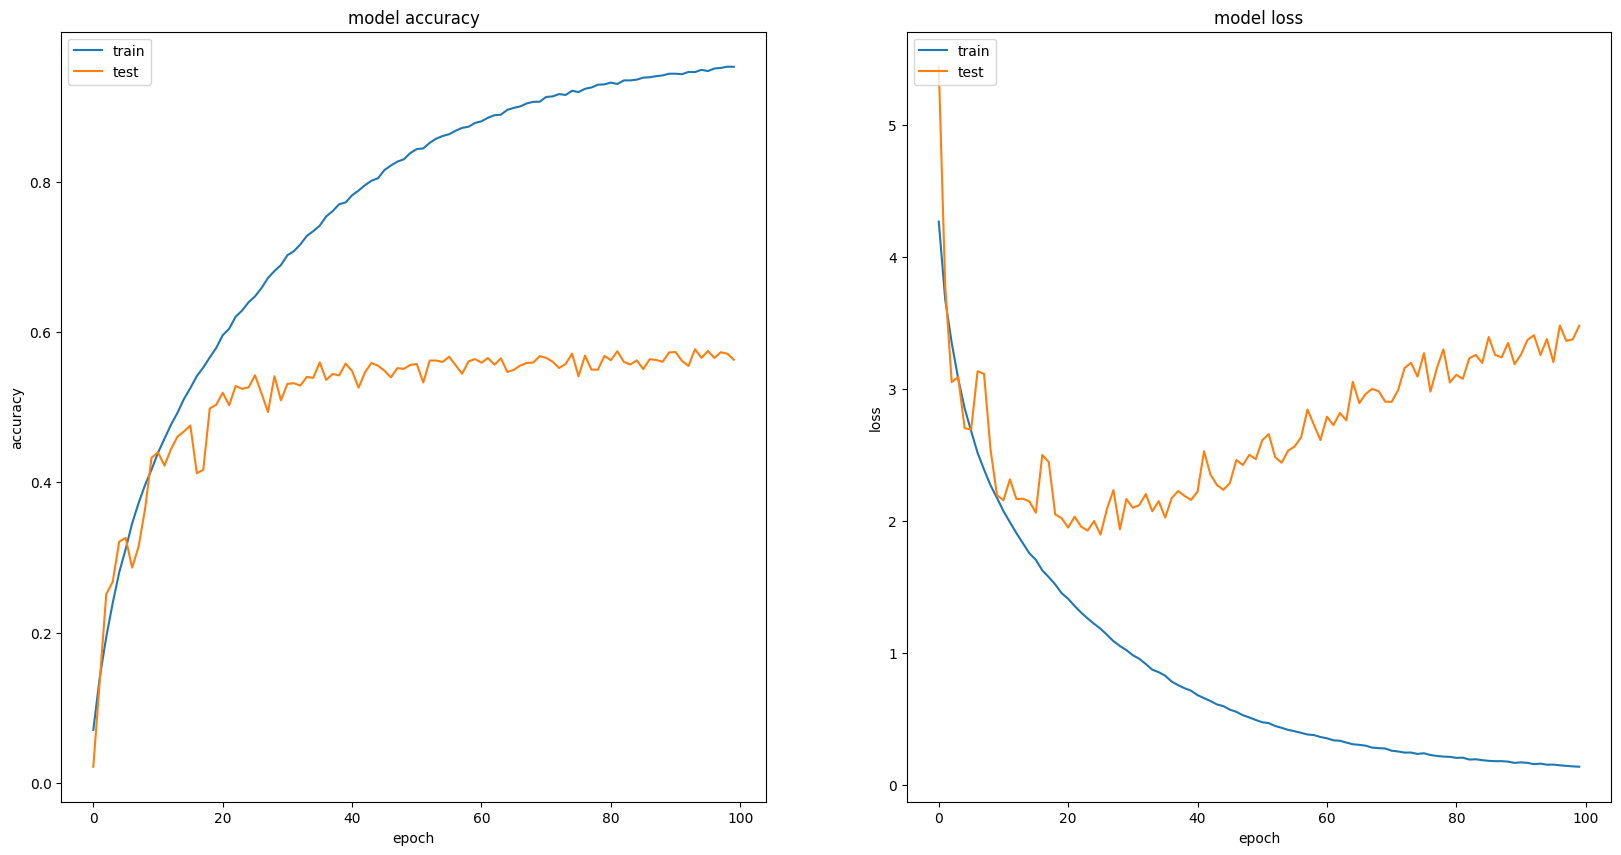

79/79 [==============================] - 1s 11ms/step - loss: 3.3941 - accuracy: 0.5741

Test score/loss: 3.394113302230835
Test accuracy: 0.5741000175476074
NEW ACCURACY <= BEST ACCURACY    0.5741000175476074 <= 0.4902999997138977
NEW LOSS <= BEST LOSS    3.394113302230835 >= 1.9687711000442505
BEST EXPERIMENT: 4


In [ ]:
history_5 = model_5.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)
analyse_model(model=model_5, history=history_5, experiment=5)

## Experiment 6: Train with Best Hyperparameters
Here the best hyperparameters are utilised to train the model. Some further adjustments have been made, to improve performance further also. These include:
- Exponential learning rate decay
- Model checkpoint, monitoring the best validation loss & therefore best model
- Data Augmentation

### Setup

In [ ]:
lr_schedule = ExponentialDecay(
    1e-3,
    decay_steps=312,
    decay_rate=0.99,
    staircase=False)

OPTIM = RMSprop(learning_rate=lr_schedule)

In [ ]:
checkpoint_dir = os.path.join(model_dir, "best_model_6.weights.h5")

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir,
    monitor='val_loss',
    save_weights_only=True,
    mode='min',
    save_best_only=True)

In [ ]:
datagen = ImageDataGenerator(
   rotation_range=20,
   horizontal_flip=True,
   fill_mode='nearest',
   validation_split=VALIDATION_SPLIT)

### Training

In [ ]:
model_6 = create_experiment5_arch(cnn_units=cnn_units, res_blocks=res_blocks)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 32, 32, 256)          7168      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_28 (Ba  (None, 32, 32, 256)          1024      ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 256)          0         ['batch_normalization_28

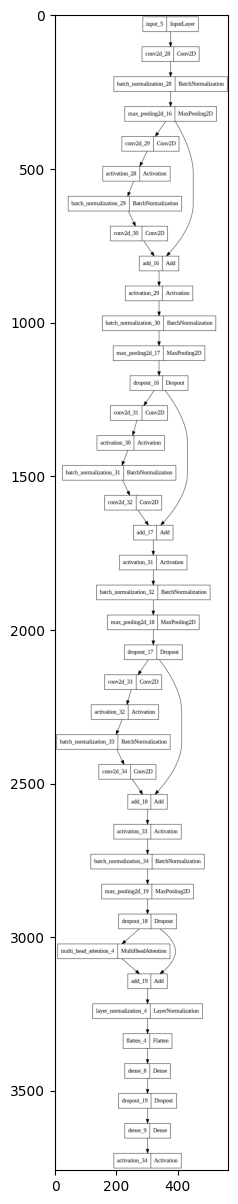

In [ ]:
model_6.summary()
plot_save_model(model_6, filename="experiment_6_arch.png")

In [ ]:
steps_per_epoch = ((input_X_train.shape[0]//BATCH_SIZE) * (1 - VALIDATION_SPLIT))
history_6 = model_6.fit(datagen.flow(input_X_train, output_Y_train, batch_size=BATCH_SIZE, subset='training'), validation_data=(datagen.flow(input_X_train, output_Y_train, batch_size=BATCH_SIZE, subset='validation')), steps_per_epoch=steps_per_epoch, epochs=N_EPOCH, verbose=VERBOSE)


Epoch 1/100
312/312 [==============================] - 37s 109ms/step - loss: 4.1611 - accuracy: 0.0705 - val_loss: 4.9435 - val_accuracy: 0.0293
Epoch 2/100
312/312 [==============================] - 33s 104ms/step - loss: 3.5353 - accuracy: 0.1580 - val_loss: 3.4984 - val_accuracy: 0.1660
Epoch 3/100
312/312 [==============================] - 33s 104ms/step - loss: 3.1850 - accuracy: 0.2204 - val_loss: 3.1268 - val_accuracy: 0.2274
Epoch 4/100
312/312 [==============================] - 32s 102ms/step - loss: 2.9135 - accuracy: 0.2710 - val_loss: 2.8515 - val_accuracy: 0.2821
Epoch 5/100
312/312 [==============================] - 32s 101ms/step - loss: 2.6886 - accuracy: 0.3127 - val_loss: 2.8304 - val_accuracy: 0.3016
Epoch 6/100
312/312 [==============================] - 31s 99ms/step - loss: 2.4943 - accuracy: 0.3532 - val_loss: 2.5331 - val_accuracy: 0.3462
Epoch 7/100
312/312 [==============================] - 30s 97ms/step - loss: 2.3462 - accuracy: 0.3818 - val_loss: 2.4018 - v

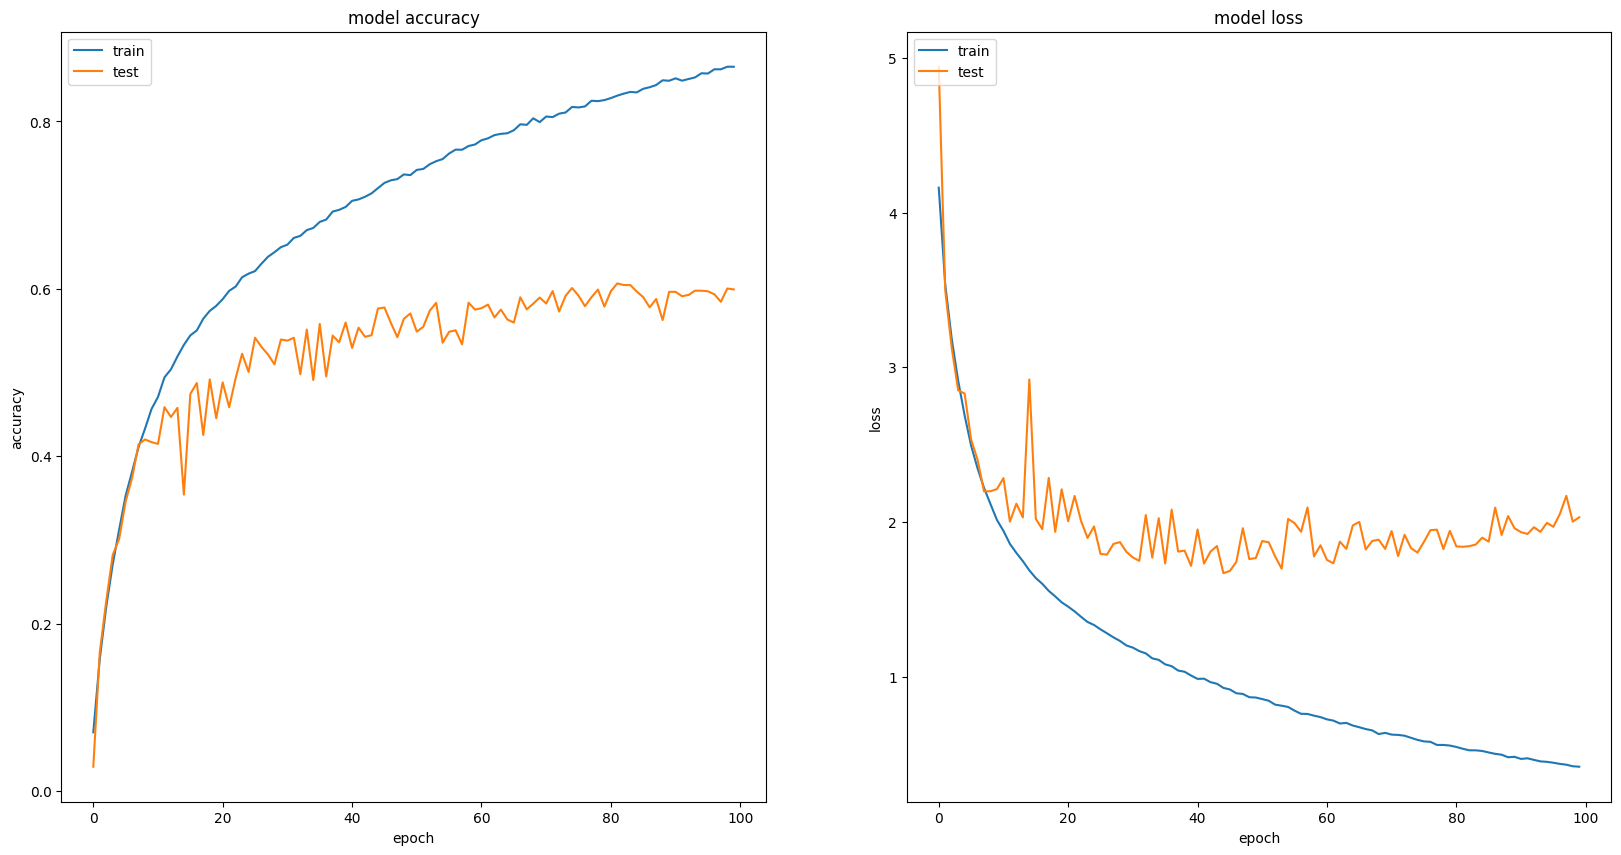

79/79 [==============================] - 1s 12ms/step - loss: 1.9774 - accuracy: 0.6113

Test score/loss: 1.9773552417755127
Test accuracy: 0.611299991607666
NEW ACCURACY <= BEST ACCURACY    0.611299991607666 <= 0.4902999997138977
NEW LOSS <= BEST LOSS    1.9773552417755127 >= 1.9687711000442505
BEST EXPERIMENT: 4


In [ ]:
model_6.load_weights(checkpoint_dir)
analyse_model(model=model_6, history=history_6, experiment=6)

# Final Analysis
This section gets the plotted history of each of the experiments and plots them together, comparing the different results

In [ ]:
experiment_names = ["1. Basic CNN", "2. CNN with Res", "3. CNN with Attention", "4. CNN, Res, Attention", "5. CNN, Res, Attention Opt", "6. Final"]

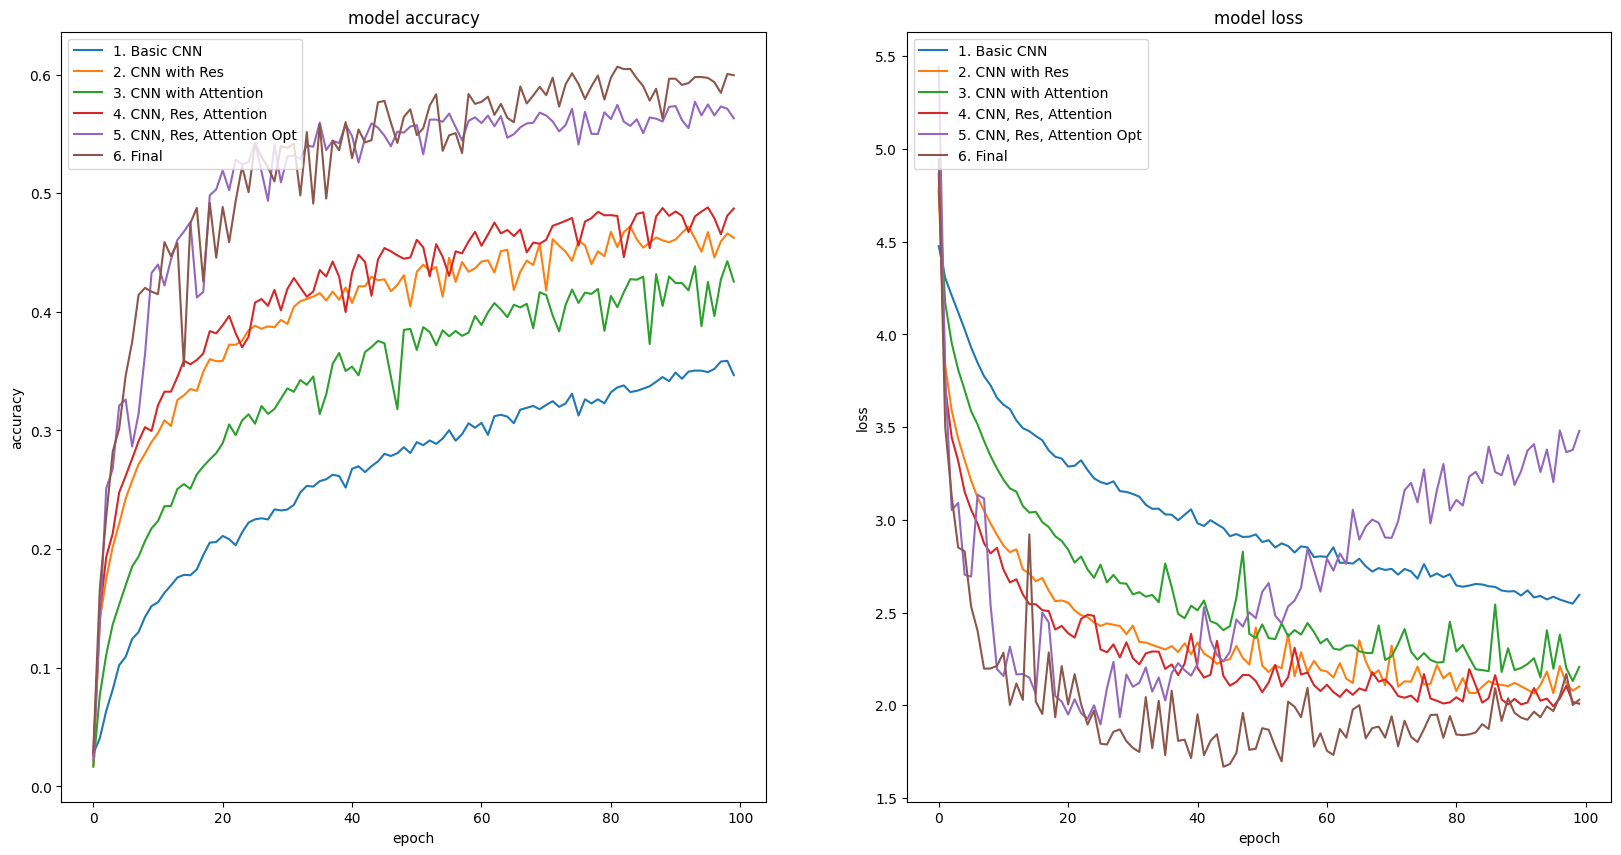

In [ ]:
plot_multiple_histories(histories=HISTORIES, export_path="all_experiments.pdf", legend=experiment_names, include_train = False)

Finally, with the best model the confusion matrix is constructed

In [21]:
with open(os.path.join(model_dir, "model_6.json"), "r") as f:
    model_architecture = json.loads(f.read())
model_6 = keras.models.model_from_json(model_architecture)
model_6.load_weights(os.path.join(model_dir, "model_6.hdf5"))

313/313 [==============================] - 1s 3ms/step


<ipython-input-14-a185e3057a50>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(CIFAR_CLASSES)
<ipython-input-14-a185e3057a50>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(CIFAR_CLASSES)


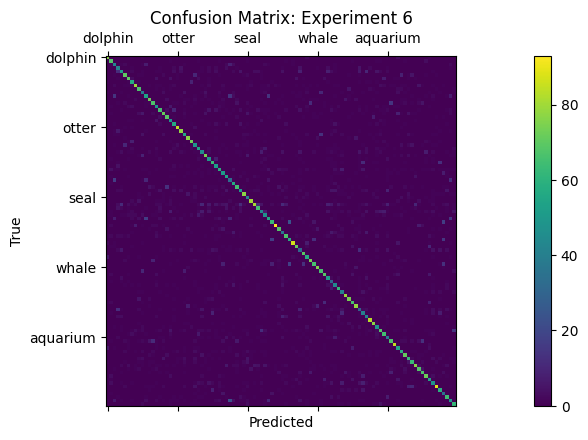

                   precision    recall  f1-score   support

           beaver      0.906     0.770     0.832       100
          dolphin      0.829     0.680     0.747       100
            otter      0.566     0.430     0.489       100
             seal      0.532     0.410     0.463       100
            whale      0.361     0.530     0.429       100
         aquarium      0.636     0.700     0.667       100
             fish      0.648     0.700     0.673       100
              ray      0.731     0.570     0.640       100
            shark      0.608     0.790     0.687       100
            trout      0.728     0.670     0.698       100
          orchids      0.452     0.380     0.413       100
          poppies      0.443     0.540     0.486       100
            roses      0.673     0.720     0.696       100
       sunflowers      0.532     0.670     0.593       100
           tulips      0.588     0.500     0.541       100
          bottles      0.524     0.660     0.584       

In [24]:
make_confusion_matrix(model=model_6, filename="Final_Confusion_Matrix.png", experiment=6)